In [1]:
import math

# import import_ipynb
# from utils import df_from_csv, to_be_checked, is_corr_ok, plot_hist, plot_boxes, plot_lines, df_to_csv, drop_pm25_outliers

# with the new api
from importnb import imports
with imports("ipynb"):
    from utils import df_from_csv, to_be_checked, is_corr_ok, plot_hist, plot_boxes, plot_lines, df_to_csv, drop_pm25_outliers

PM2.5: 35.9, AQI: 102
PM2.5: 35.9, Measure Level: MeasureLevels.UNHEALTHY_FOR_SENSITIVE_GROUPS, Range Values: Min: 35.5, Max: 55.4
AQI: 102, Measure Level: MeasureLevels.UNHEALTHY_FOR_SENSITIVE_GROUPS, Range Values: Min: 101, Max: 150


## PM2.5 Clean Data

In [2]:
# Load Raw Data
df_pm25_raw = df_from_csv("pm25_raw.csv")

# Check Data Types
print(df_pm25_raw.dtypes)

df_pm25_raw.head()

TANGARA_260A    float64
TANGARA_14D6    float64
TANGARA_2B42    float64
TANGARA_2E9A    float64
TANGARA_2FF6    float64
TANGARA_307A    float64
TANGARA_1712    float64
TANGARA_48C6    float64
TANGARA_532E    float64
TANGARA_F1AE    float64
TANGARA_06BE    float64
dtype: object


,TANGARA_260A,TANGARA_14D6,TANGARA_2B42,TANGARA_2E9A,TANGARA_2FF6,TANGARA_307A,TANGARA_1712,TANGARA_48C6,TANGARA_532E,TANGARA_F1AE,TANGARA_06BE
DATETIME,,,,,,,,,,,
2023-10-30 00:00:30-05:00,17.0,24.0,10.0,4.0,18.0,6.0,5.0,11.0,4.0,24.0,17.0
2023-10-30 00:01:00-05:00,19.0,26.0,9.0,3.0,17.0,6.0,5.0,14.0,3.0,23.0,16.0
2023-10-30 00:01:30-05:00,20.0,26.0,9.0,3.0,17.0,7.0,6.0,20.0,5.0,22.0,15.0
2023-10-30 00:02:00-05:00,19.0,27.0,9.0,4.0,17.0,7.0,5.0,20.0,3.0,24.0,15.0
2023-10-30 00:02:30-05:00,19.0,27.0,8.0,3.0,17.0,7.0,5.0,22.0,5.0,21.0,15.0


## Descriptive Statistics

In [3]:
# Describe Data
df_pm25_raw.describe()

,TANGARA_260A,TANGARA_14D6,TANGARA_2B42,TANGARA_2E9A,TANGARA_2FF6,TANGARA_307A,TANGARA_1712,TANGARA_48C6,TANGARA_532E,TANGARA_F1AE,TANGARA_06BE
count,1306.000000,2668.000000,2686.000000,2655.000000,2672.000000,2637.000000,2645.000000,2545.000000,2689.000000,2693.000000,2671.000000
mean,15.796325,12.460645,10.615413,9.358569,9.593563,8.252939,7.185633,9.435363,9.908888,11.301151,13.345563
std,3.866332,6.600010,7.279259,7.996576,4.584030,3.439499,2.943226,5.564502,19.316084,6.231980,8.067739
min,8.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
25%,13.000000,7.000000,7.000000,3.000000,7.000000,6.000000,5.000000,5.000000,3.000000,7.000000,10.000000
50%,16.000000,13.000000,9.000000,8.000000,9.000000,8.000000,7.000000,8.000000,8.000000,11.000000,12.000000
75%,18.000000,17.000000,13.000000,12.000000,11.000000,10.000000,9.000000,14.000000,13.000000,15.000000,16.000000
max,65.000000,43.000000,33.000000,129.000000,22.000000,60.000000,23.000000,40.000000,748.000000,35.000000,129.000000


## Missing Data

In [4]:
# Missing Data Threshold
threshold = 90
print(f'Threshold: {threshold}%')

# For each Tangara sensor
for id_tangara_sensor in df_pm25_raw.columns:
    df_pm25_sensor = df_pm25_raw[[id_tangara_sensor]]
    # To be checked
    is_ok, data_percent, missing_data_percent = to_be_checked(df_pm25_sensor, threshold)
    if not is_ok:
        print(f"Tangara Sensor: {id_tangara_sensor}, Data: {data_percent}%, Missing: {missing_data_percent}%, To be checked")

Threshold: 90%
Tangara Sensor: TANGARA_260A, Data: 47%, Missing: 53%, To be checked


/home/sebaxtian/Workspaces/Tangara/tangara-pipeline/standalone/notebooks/utils.ipynb:197: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  missing_data_percent = round(df_sensor.isna().sum()[0] * 100 / total)
/home/sebaxtian/Workspaces/Tangara/tangara-pipeline/standalone/notebooks/utils.ipynb:198: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data_percent = round(df_sensor.count()[0] * 100 / total)
/home/sebaxtian/Workspaces/Tangara/tangara-pipeline/standalone/notebooks/utils.ipynb:197: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as

## Data Correlation

In [5]:
# Data Correlation Threshold
threshold = 0.9
print(f'Threshold: {threshold}%')

ID_REFE_TANGARA_SENSOR='TANGARA_06BE'
ID_TARG_TANGARA_SENSOR='TANGARA_2FF6'
# Reference Tangara Sensor
df_reference_sensor = df_pm25_raw[ID_REFE_TANGARA_SENSOR]
# Target Tangara Sensor
df_target_sensor = df_pm25_raw[ID_TARG_TANGARA_SENSOR]

# To be checked
if not math.isnan(df_reference_sensor.std()):
    is_ok, corr = is_corr_ok(df_reference_sensor, df_target_sensor, threshold)
    if not is_ok:
        print(f"Reference Tangara Sensor: {ID_REFE_TANGARA_SENSOR}, Target Tangara Sensor: {ID_TARG_TANGARA_SENSOR}, Correlation: {corr}, To be checked")

# For each Tangara sensor
# for id_tangara_sensor in df_pm25_raw.columns:
#     # Target Tangara Sensor
#     df_target_sensor = df_pm25_raw[id_tangara_sensor]
#     # To be checked
#     is_ok, corr = is_corr_ok(df_reference_sensor, df_target_sensor, threshold)
#     if not is_ok:
#         print(f"Reference Tangara Sensor: {ID_REFE_TANGARA_SENSOR}, Target Tangara Sensor: {id_tangara_sensor}, Correlation: {corr}, To be checked")

Threshold: 0.9%
Reference Tangara Sensor: TANGARA_06BE, Target Tangara Sensor: TANGARA_2FF6, Correlation: 0.0, To be checked


## Histograms

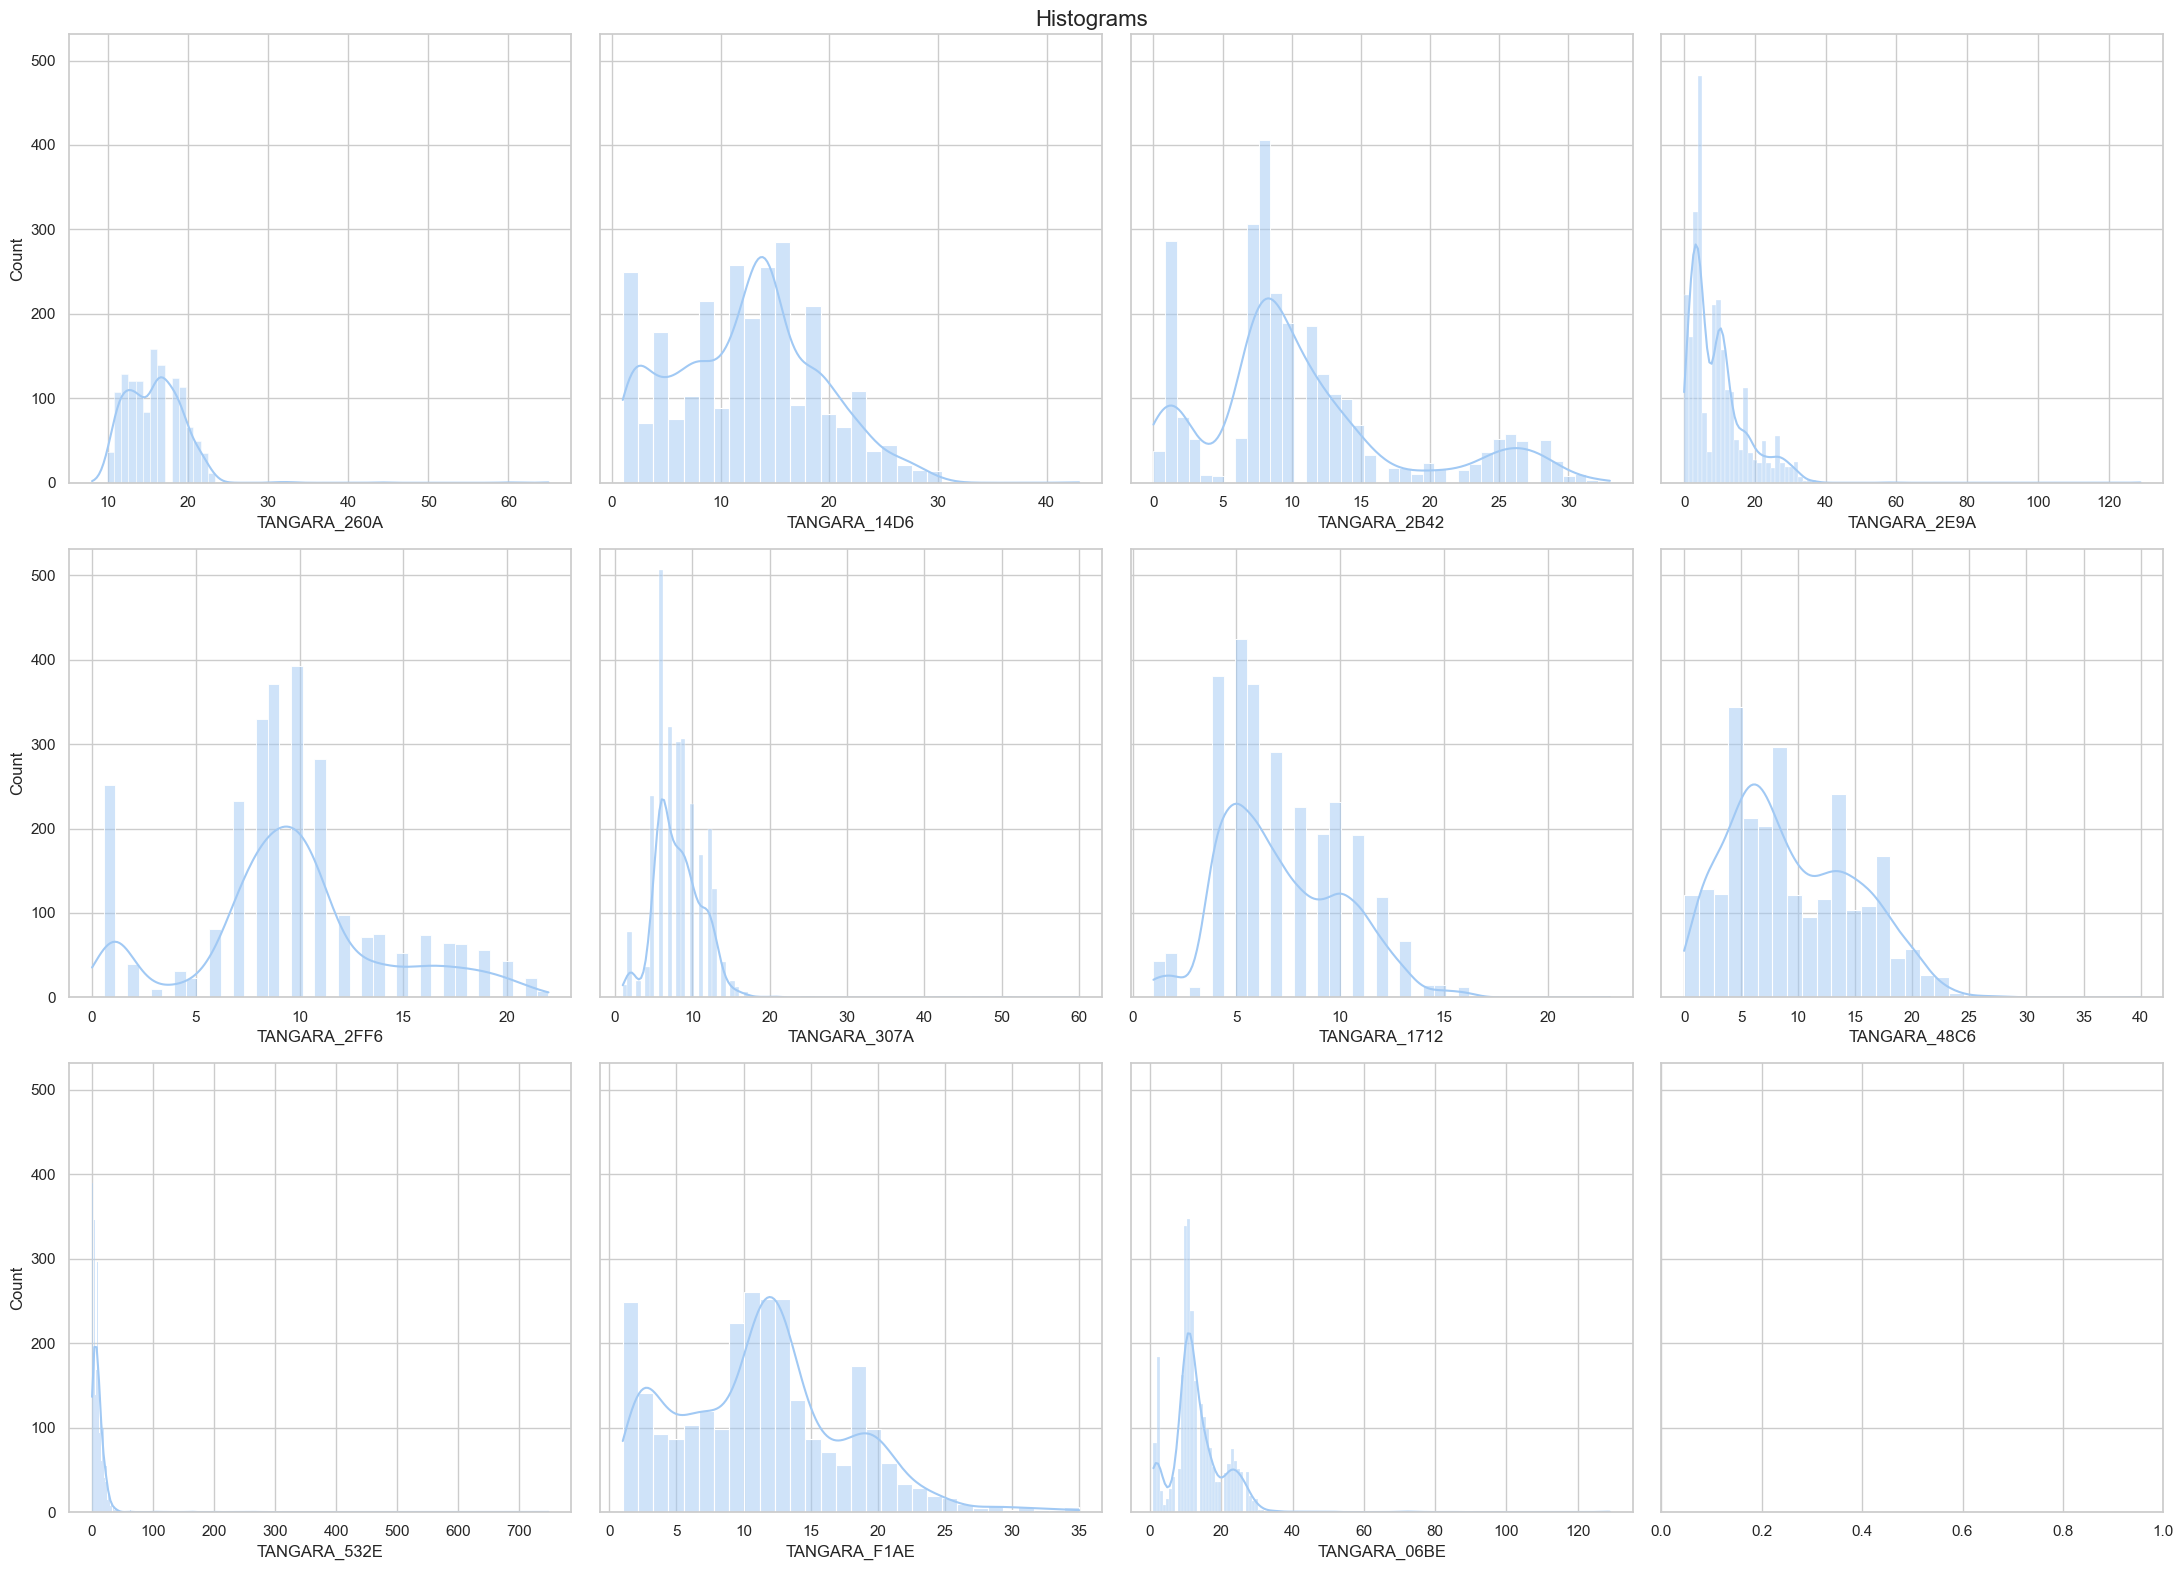

In [6]:
# Plot Histograms
plot_hist(df_pm25_raw)

## Boxplots

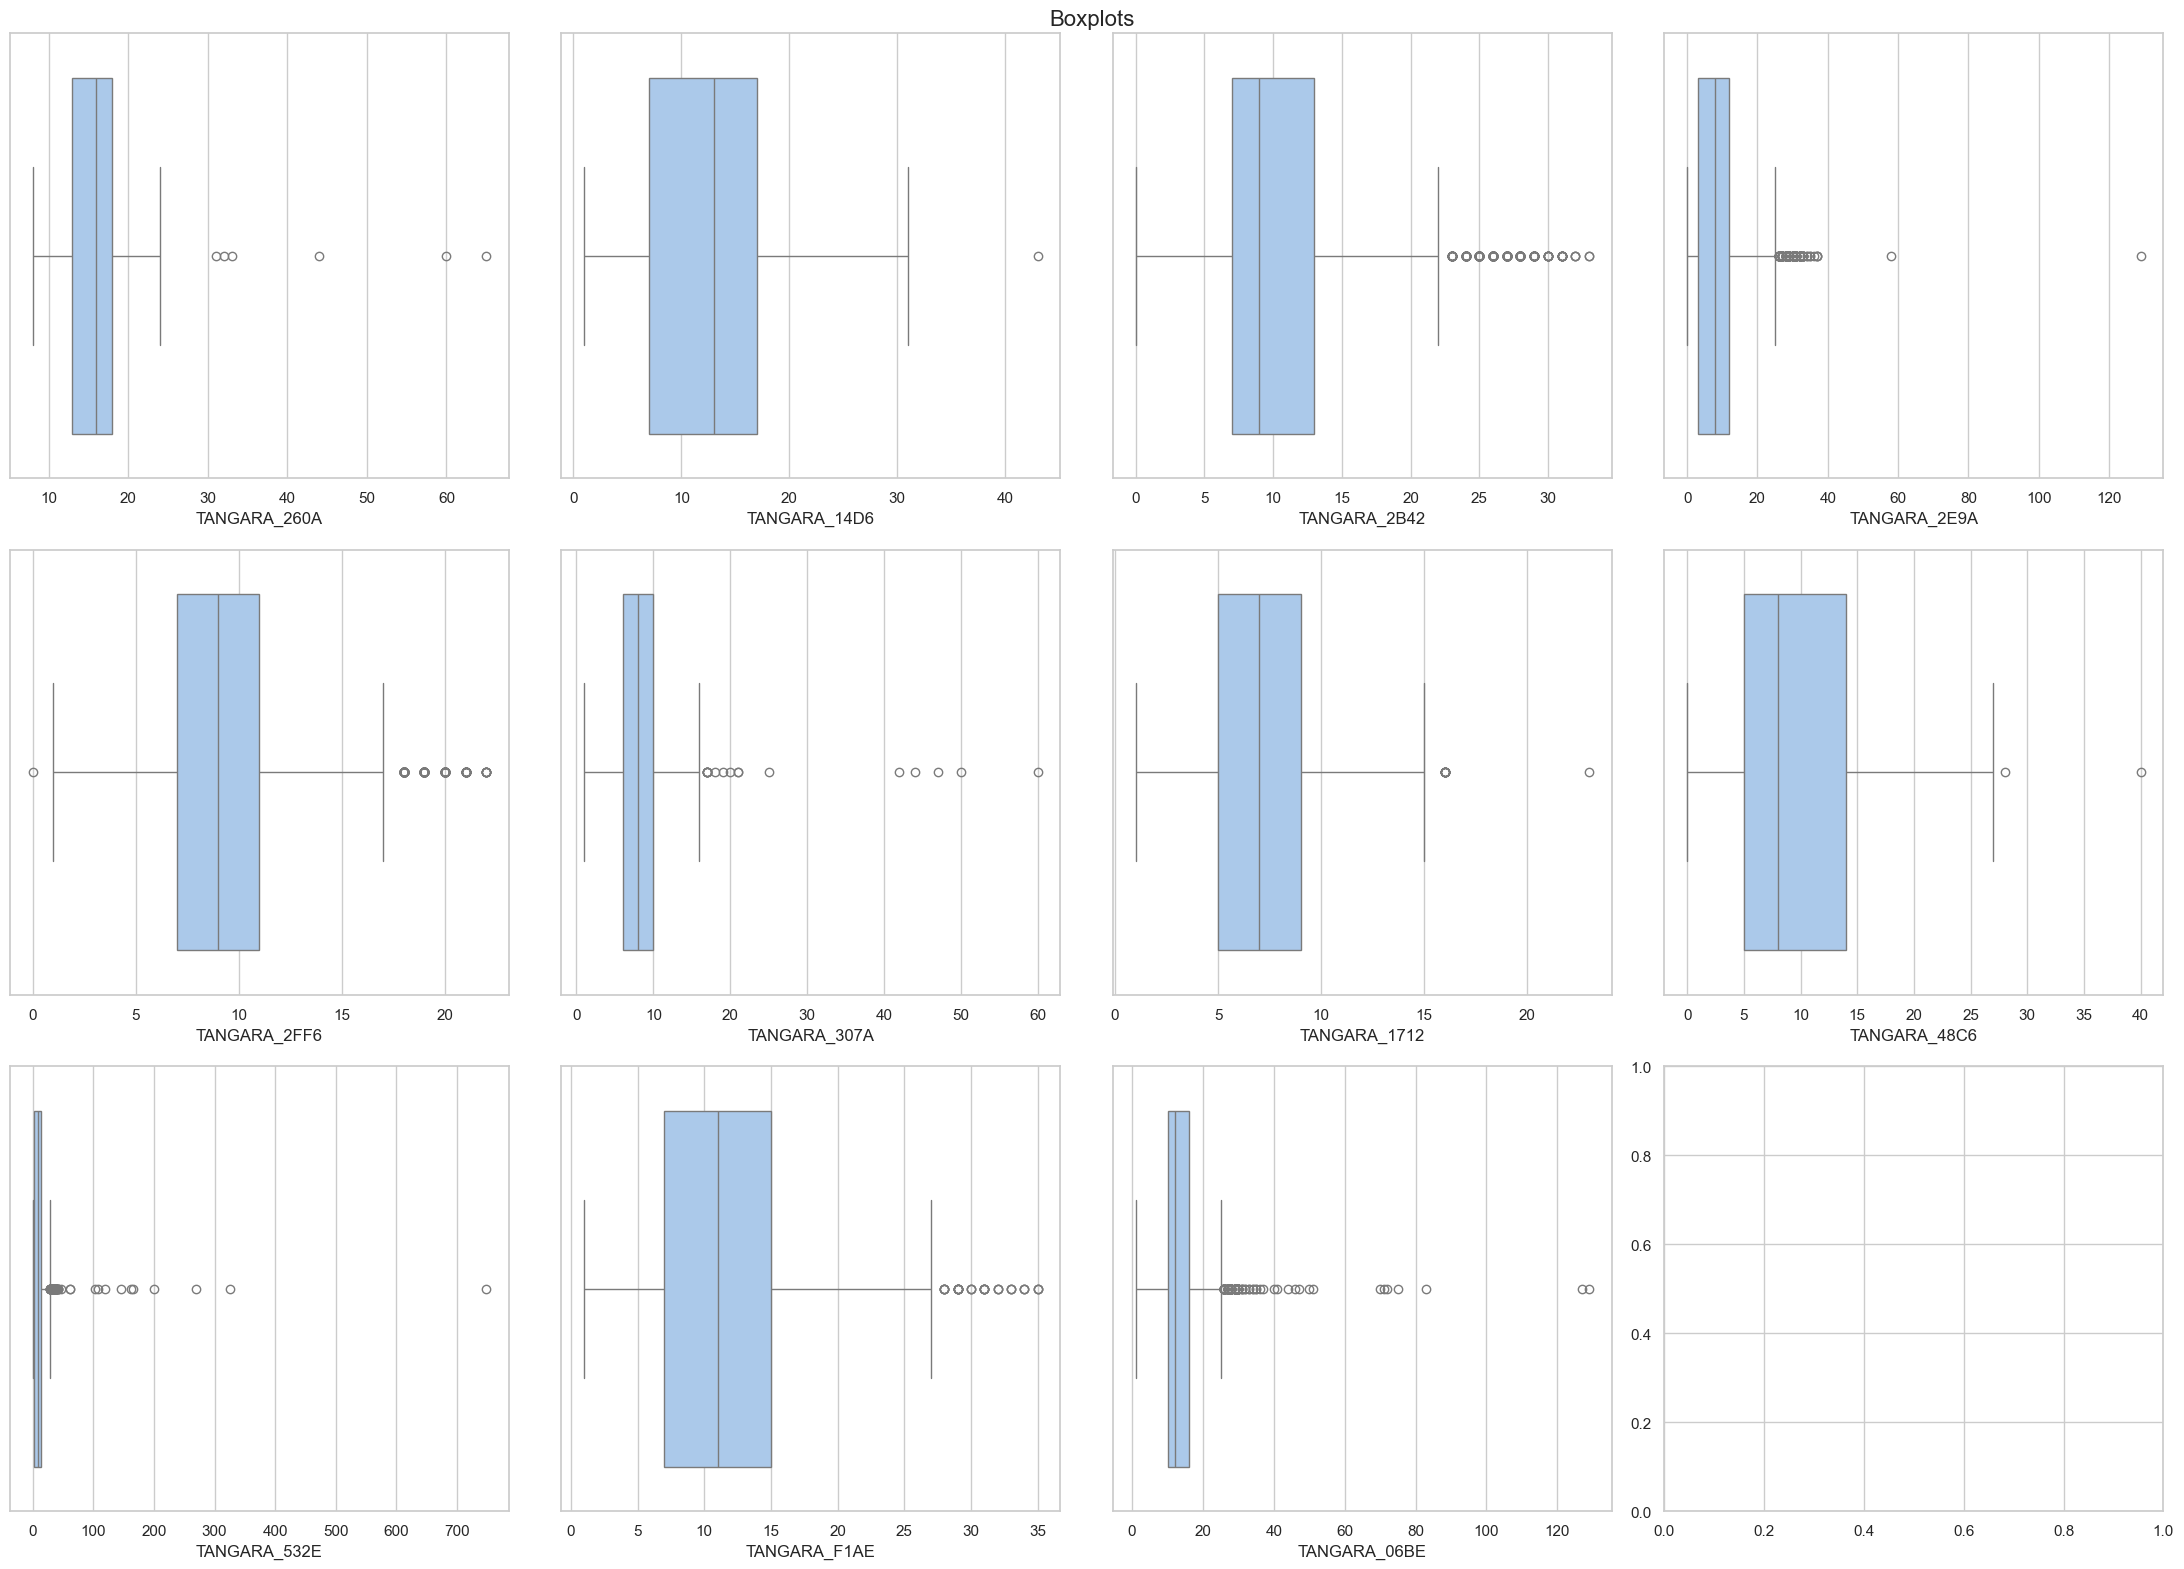

In [7]:
# Plot Boxplots
plot_boxes(df_pm25_raw)

## Lineplots

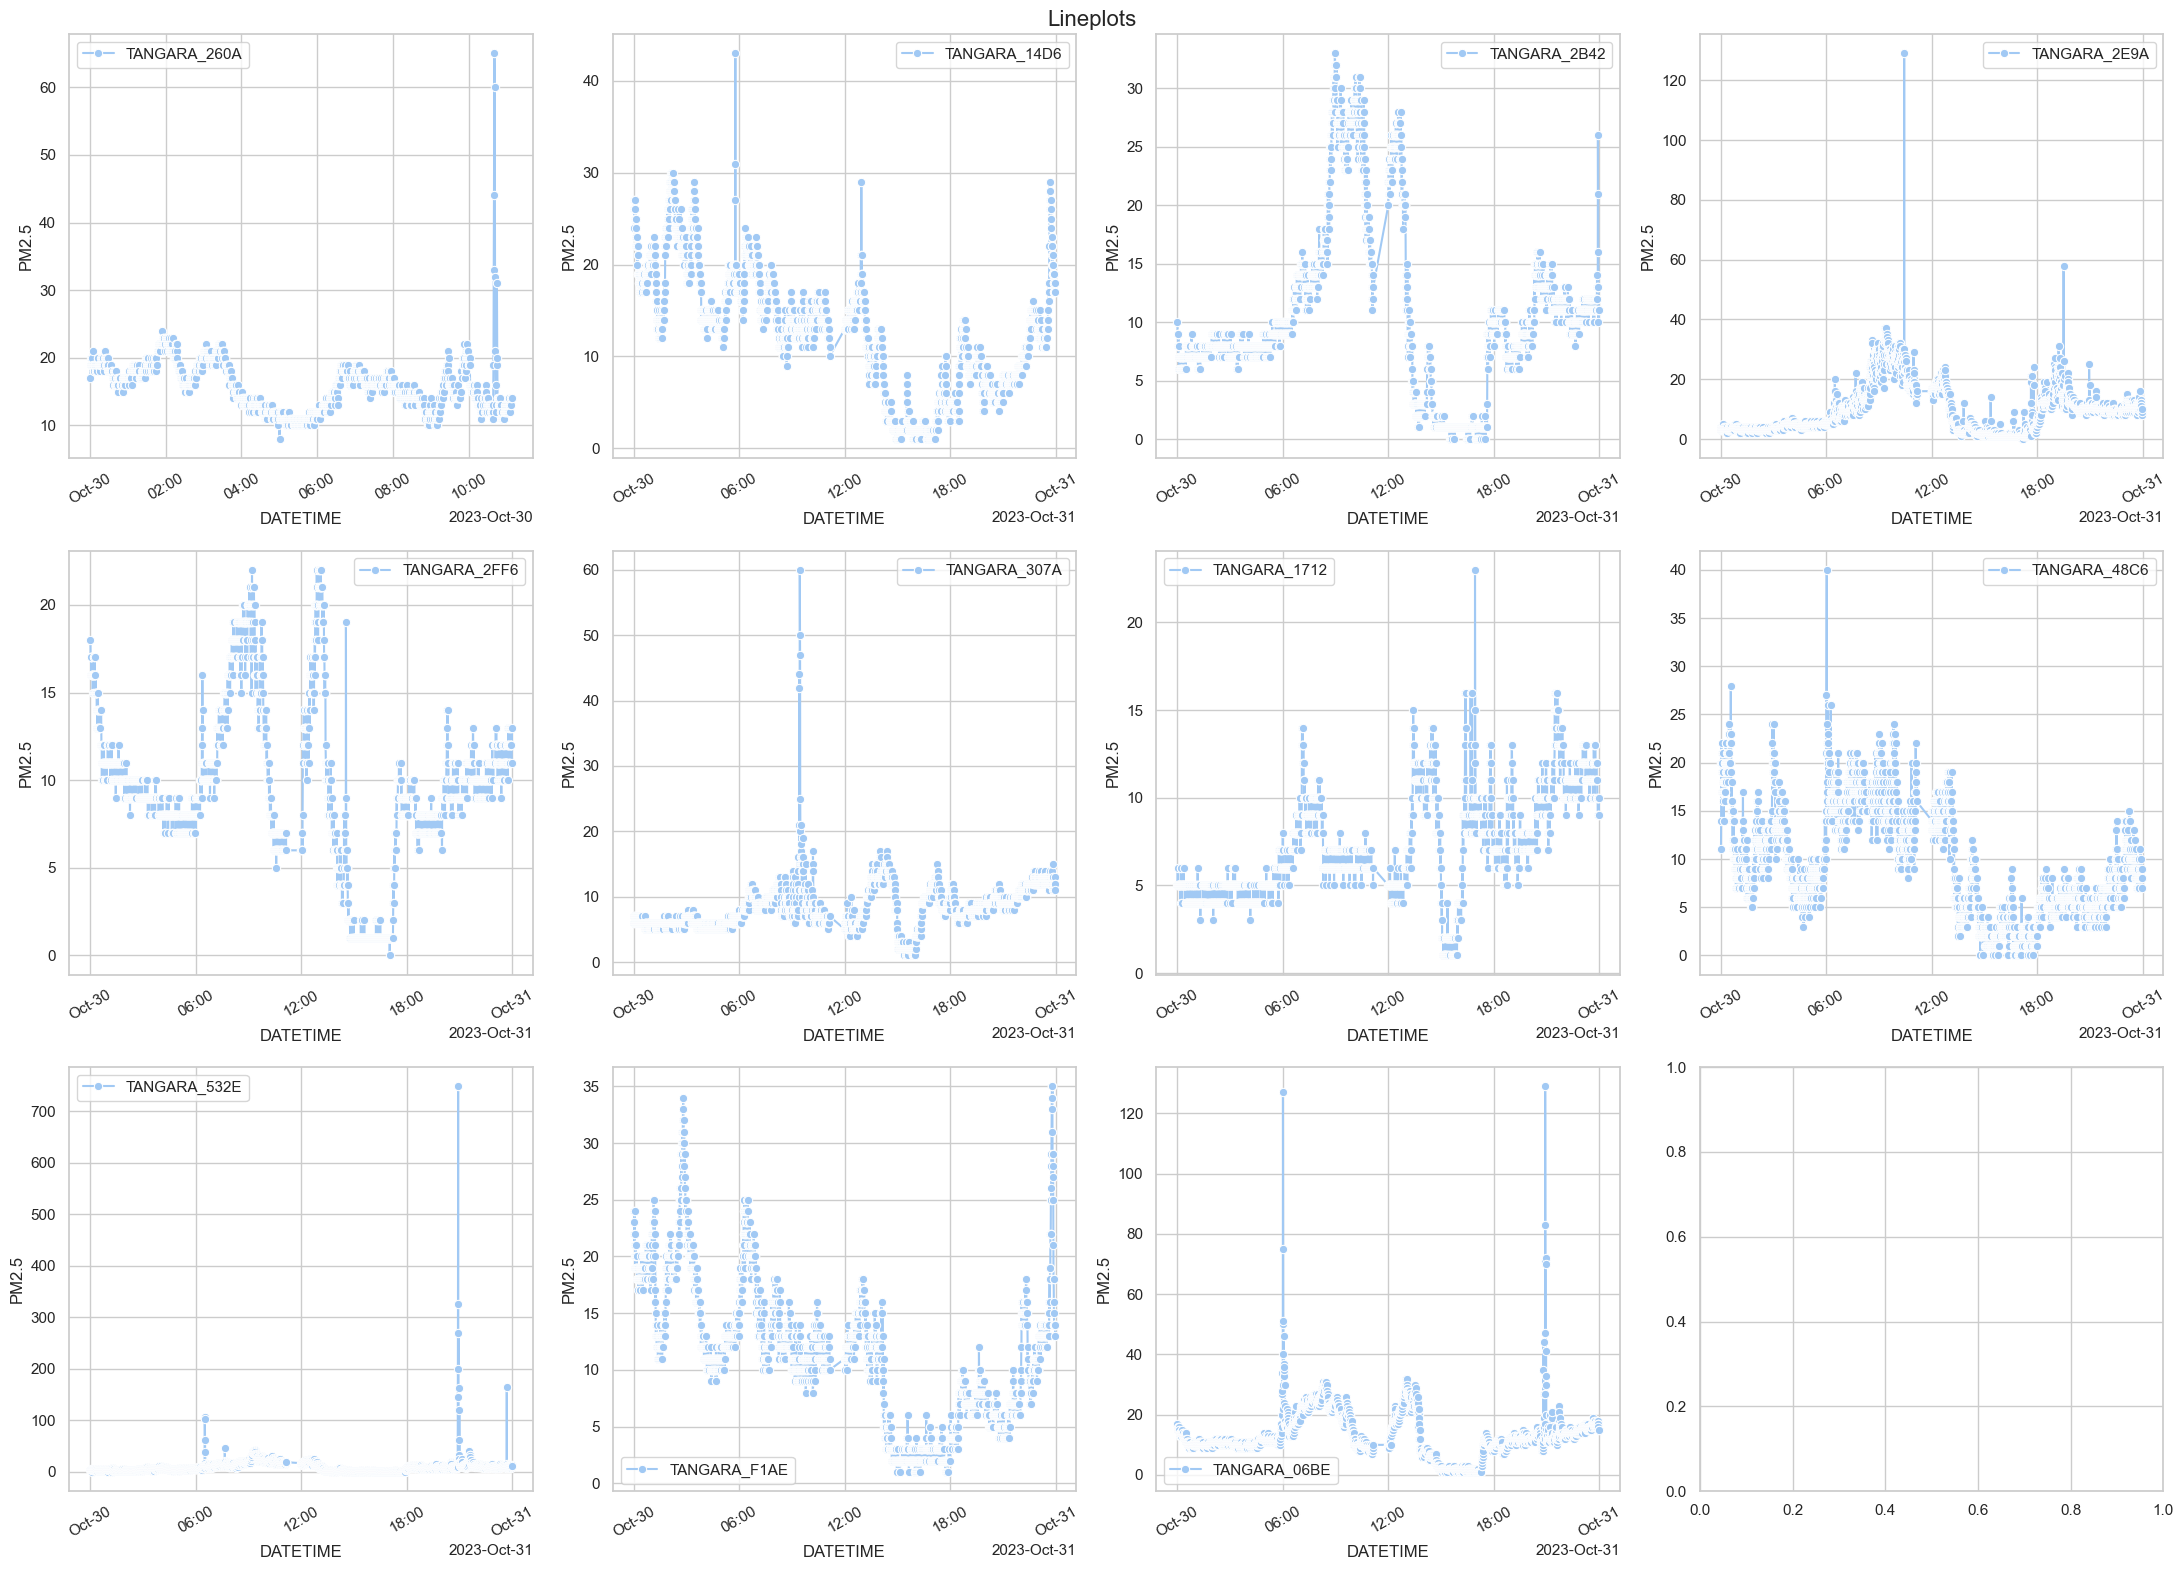

In [8]:
# Plot Lineplots
plot_lines(df_pm25_raw)

## Drop PM2.5 Outliers

In [9]:
# Drop PM2.5 Outliers
df_pm25_clean, resume = drop_pm25_outliers(df_pm25_raw)

In [10]:
# Describe Data
df_pm25_raw.describe()

,TANGARA_260A,TANGARA_14D6,TANGARA_2B42,TANGARA_2E9A,TANGARA_2FF6,TANGARA_307A,TANGARA_1712,TANGARA_48C6,TANGARA_532E,TANGARA_F1AE,TANGARA_06BE
count,1300.000000,2667.000000,2369.000000,2497.000000,2480.000000,2620.000000,2632.000000,2543.000000,2621.000000,2659.000000,2501.000000
mean,15.665385,12.449194,8.492191,8.063276,8.846371,8.127481,7.139438,9.416044,8.497138,11.050771,12.139144
std,3.226793,6.574687,4.612982,5.921766,3.842842,2.857933,2.872948,5.521285,6.651557,5.856901,5.811354
min,8.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
25%,13.000000,7.000000,7.000000,3.000000,7.000000,6.000000,5.000000,5.000000,3.000000,6.000000,10.000000
50%,16.000000,13.000000,8.000000,6.000000,9.000000,8.000000,7.000000,8.000000,8.000000,11.000000,11.000000
75%,18.000000,17.000000,11.000000,11.000000,11.000000,10.000000,9.000000,14.000000,12.000000,14.000000,15.000000
max,24.000000,31.000000,22.000000,25.000000,17.000000,16.000000,15.000000,27.000000,28.000000,27.000000,25.000000


In [11]:
# Describe Data
df_pm25_clean.describe()

,TANGARA_260A,TANGARA_14D6,TANGARA_2B42,TANGARA_2E9A,TANGARA_2FF6,TANGARA_307A,TANGARA_1712,TANGARA_48C6,TANGARA_532E,TANGARA_F1AE,TANGARA_06BE
count,1300.000000,2667.000000,2369.000000,2497.000000,2480.000000,2620.000000,2632.000000,2543.000000,2621.000000,2659.000000,2501.000000
mean,15.665385,12.449194,8.492191,8.063276,8.846371,8.127481,7.139438,9.416044,8.497138,11.050771,12.139144
std,3.226793,6.574687,4.612982,5.921766,3.842842,2.857933,2.872948,5.521285,6.651557,5.856901,5.811354
min,8.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
25%,13.000000,7.000000,7.000000,3.000000,7.000000,6.000000,5.000000,5.000000,3.000000,6.000000,10.000000
50%,16.000000,13.000000,8.000000,6.000000,9.000000,8.000000,7.000000,8.000000,8.000000,11.000000,11.000000
75%,18.000000,17.000000,11.000000,11.000000,11.000000,10.000000,9.000000,14.000000,12.000000,14.000000,15.000000
max,24.000000,31.000000,22.000000,25.000000,17.000000,16.000000,15.000000,27.000000,28.000000,27.000000,25.000000


## Histograms

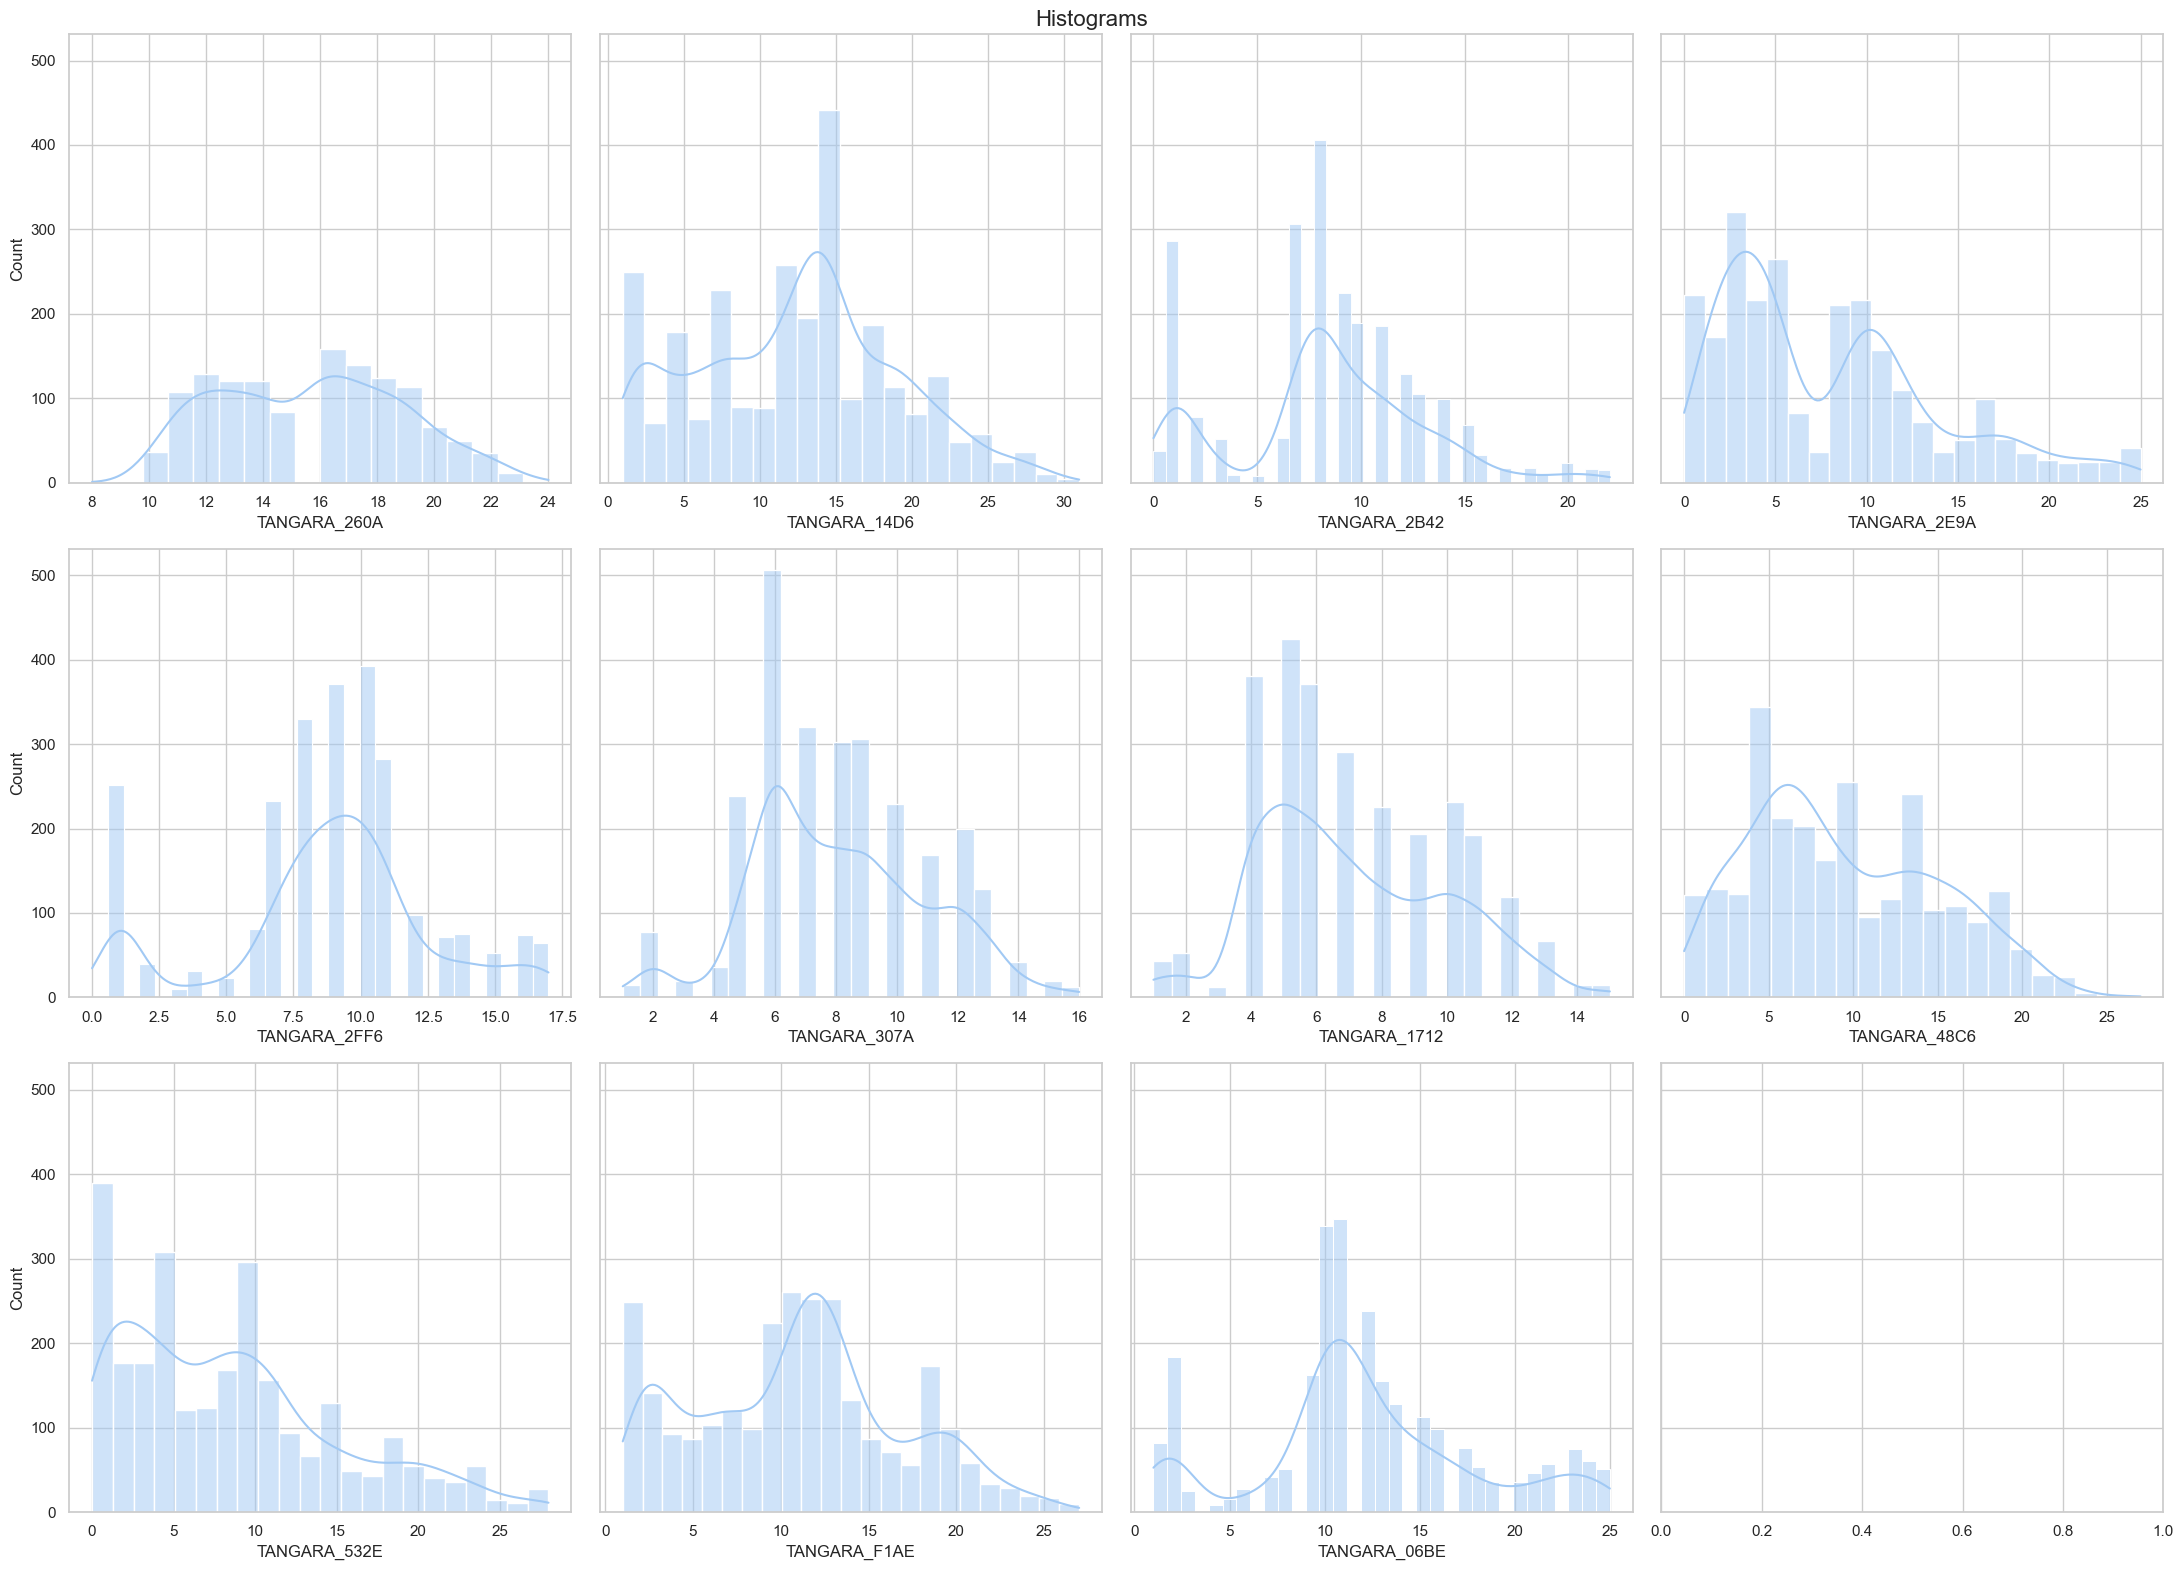

In [12]:
# Plot Histograms
plot_hist(df_pm25_clean)

## Boxplots

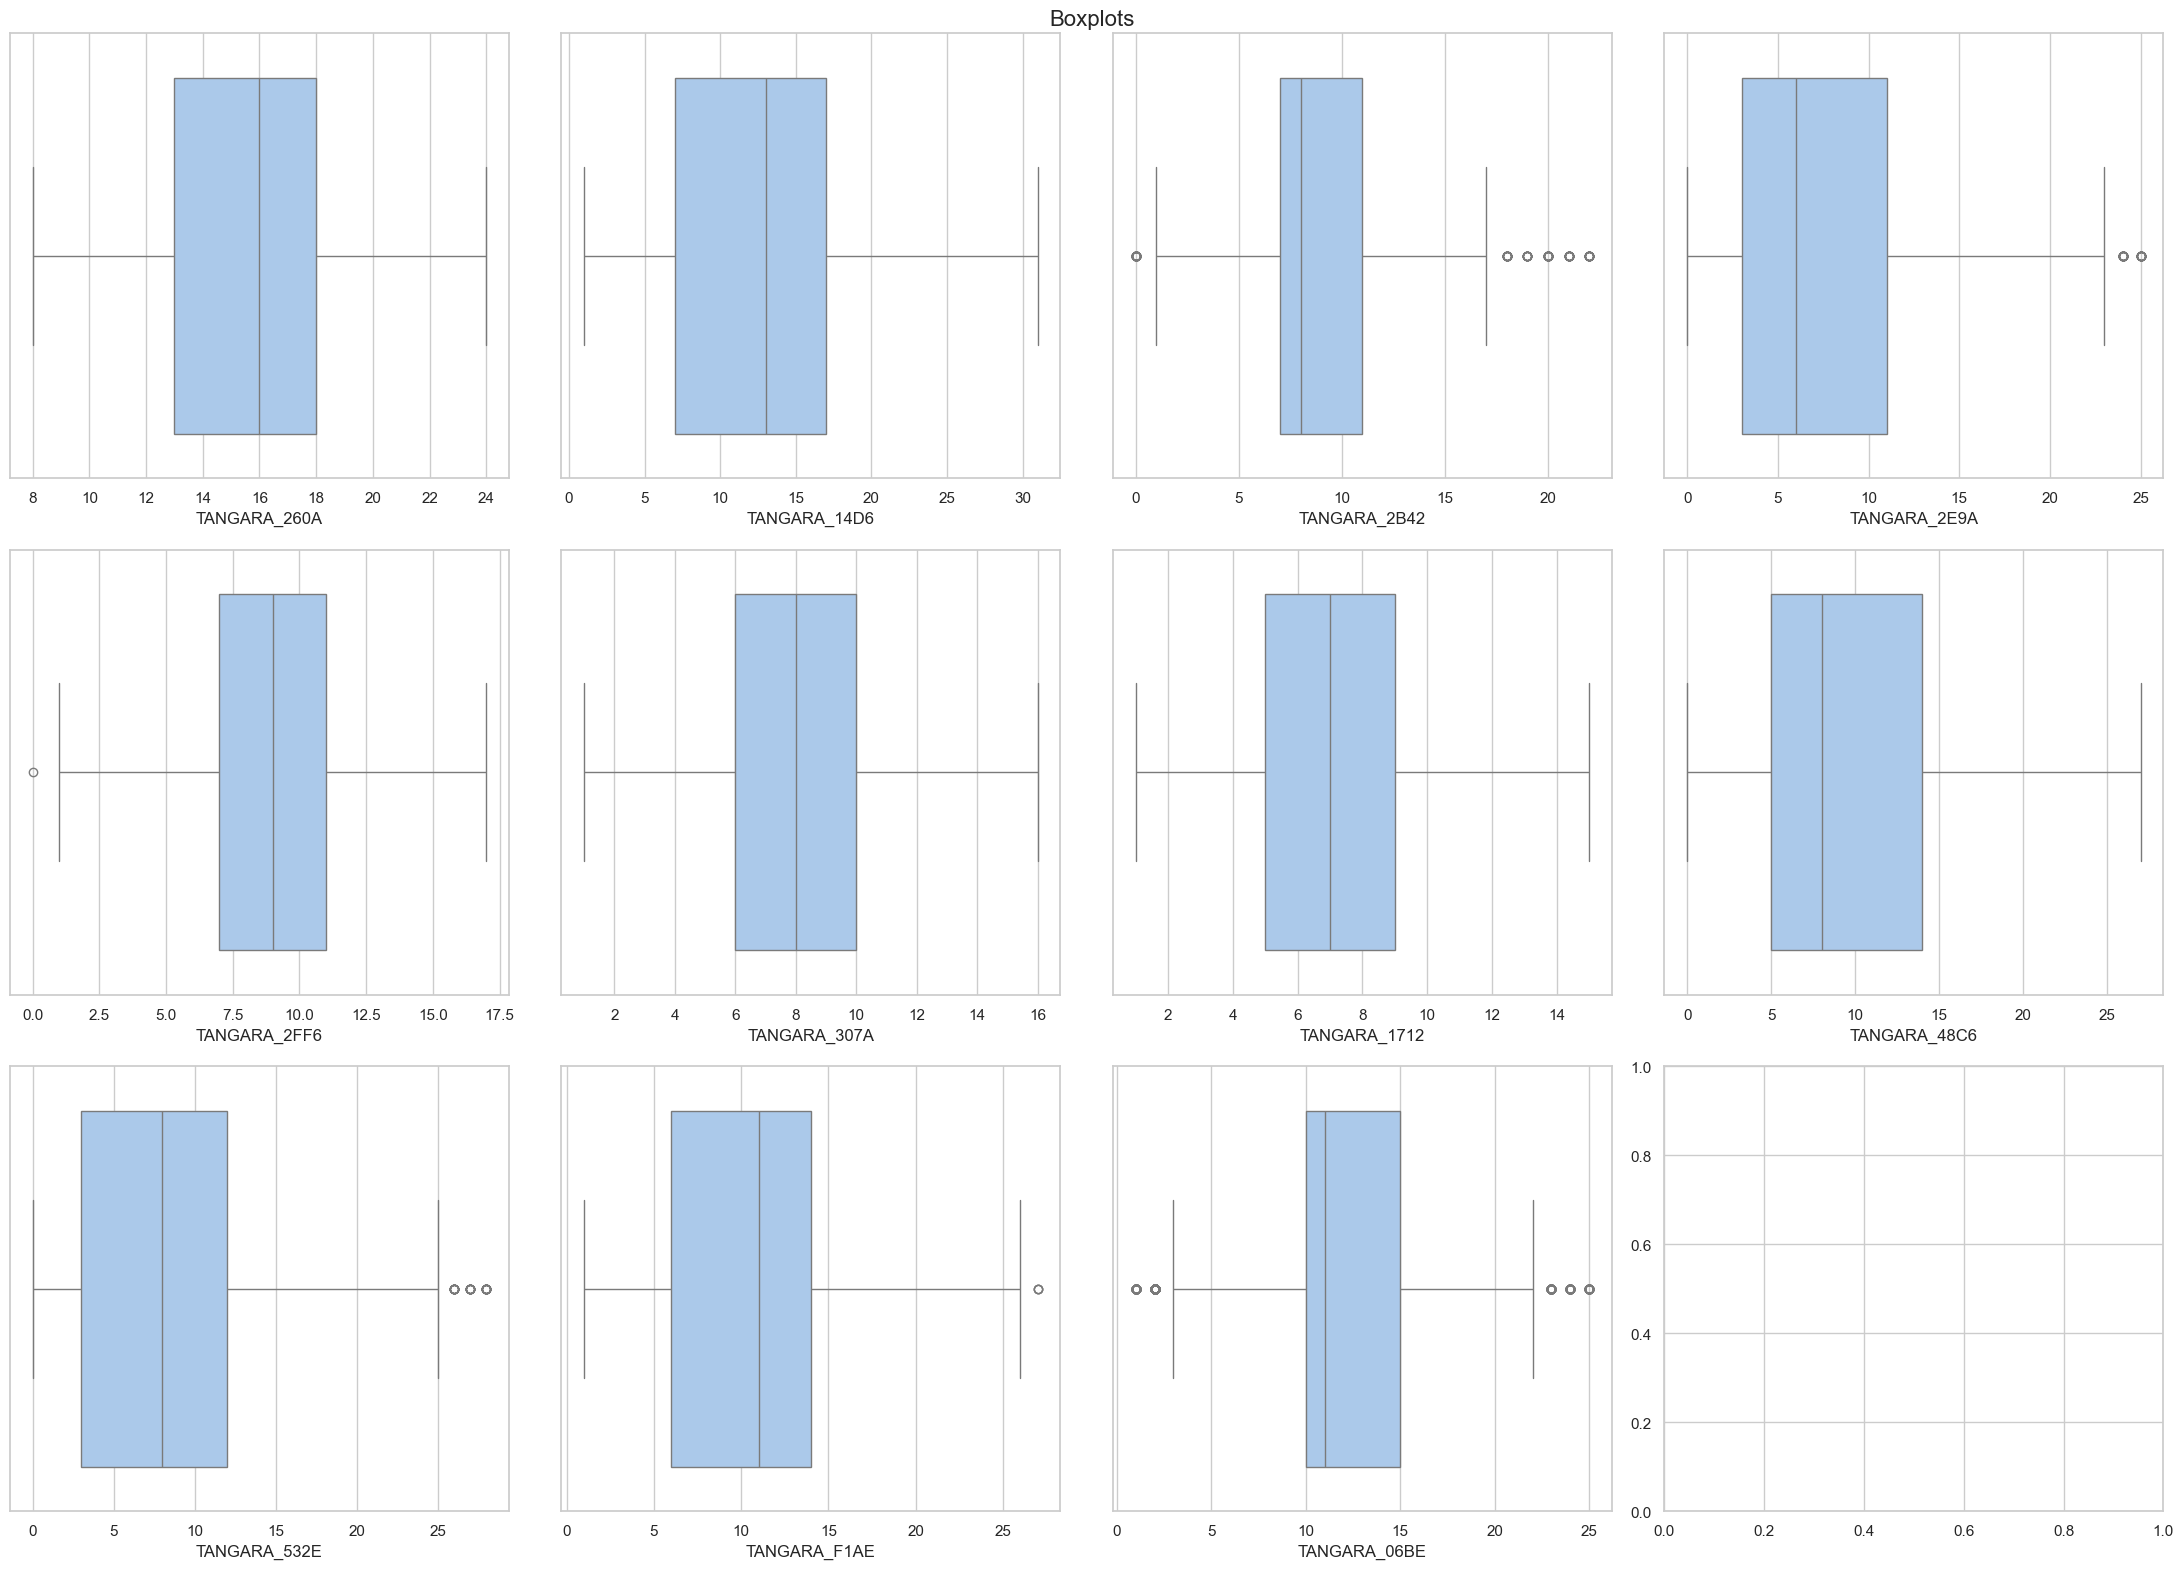

In [13]:
# Plot Boxplots
plot_boxes(df_pm25_clean)

## Lineplots

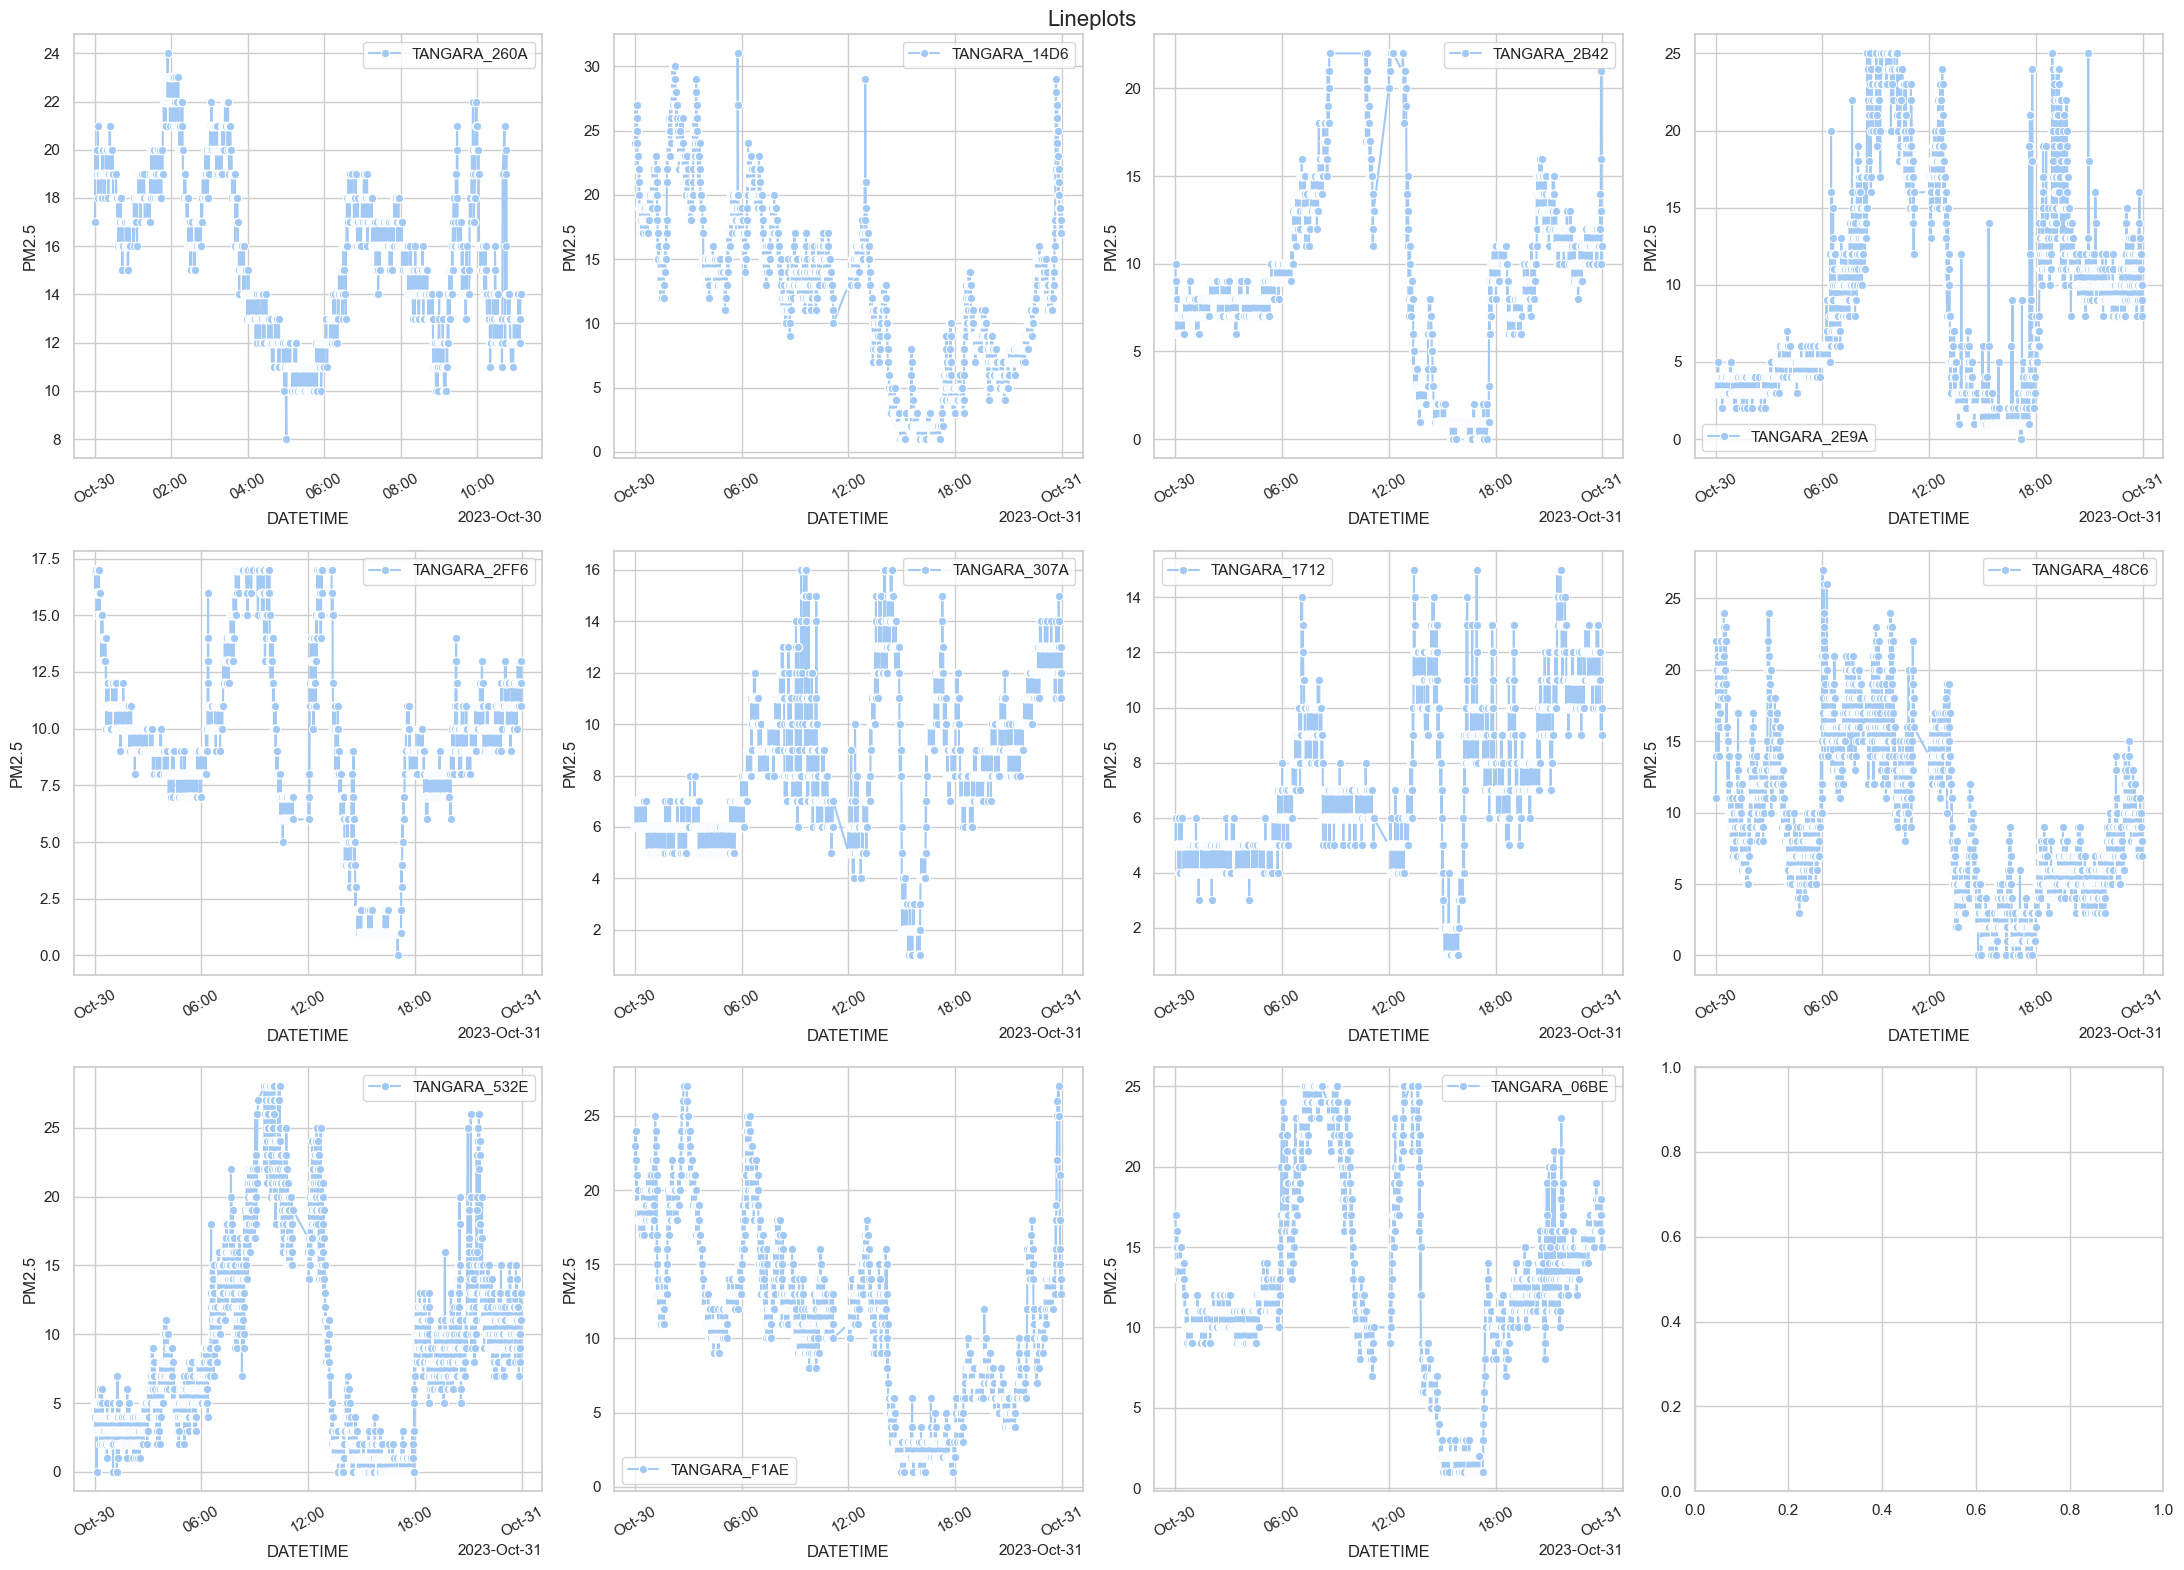

In [14]:
# Plot Lineplots
plot_lines(df_pm25_clean)

In [15]:
# Save PM2.5 Data Frame Sensors into CSV file
df_to_csv(df_pm25_clean, "pm25_clean.csv", datafolder='1_clean')